In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from theano import shared
%matplotlib inline
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [218]:
df = pd.read_csv('../other/frac_merge_peak.csv')

In [219]:
df['XEC_FIELD_Code'] = pd.Categorical(df['XEC_FIELD']).codes
df['Reservoir_Code'] = pd.Categorical(df['Reservoir']).codes

In [220]:
df.columns

Index([u'PropID', u'RSID', u'End_Date', u'Reservoir', u'Completed_Feet',
       u'#_of_Stages', u'Stage_Length', u'Clusters/Stage', u'Cluster_Spacing',
       u'Perfs/Cluster', u'Fluid_Bbls', u'Fluid_Gal/Ft', u'Fluid_Gal/Cluster',
       u'Fluid_Gal/Perf', u'Prop_Lbs', u'Prop_Lbs/Ft', u'Prop_Lbs/Cluster',
       u'Prop_Lbs/Perf', u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Avg_Rate',
       u'Max_Rate', u'Rate/Ft', u'Rate/Cluster', u'Rate/Perf', u'Avg_Pressure',
       u'Max_Pressure', u'ISIP/Ft', u'5"_SIP/Ft', u'PROPNUM', u'XEC_FIELD',
       u'OPERATOR', u'COUNTY', u'STATE', u'M_LATITUDE', u'M_LONGITUDE',
       u'MAJOR', u'SPUD_DATE', u'FIRST_PROD', u'Wet_Gas_EUR', u'Dry_Gas_EUR',
       u'Oil_EUR', u'NGL_EUR', u'Days_Production', u'OIL_Peak',
       u'OIL_Days_to_Peak', u'XEC_FIELD_Code', u'Reservoir_Code'],
      dtype='object')

In [227]:
df.groupby(['XEC_FIELD', 'XEC_FIELD_Code'])['XEC_FIELD'].count()

XEC_FIELD        XEC_FIELD_Code
COTTONWOOD DRAW  0                 14
DIXIELAND        1                 47
FORD, WEST       2                 91
GRISHAM          3                  9
PHANTOM          4                  7
RED HILLS        5                  1
STATELINE        6                  3
TWO GEORGES      7                  6
Name: XEC_FIELD, dtype: int64

In [228]:
df.groupby(['Reservoir', 'Reservoir_Code'])['Reservoir'].count()

Reservoir         Reservoir_Code
Wolfcamp Shale A  0                 89
Wolfcamp Shale C  1                 14
Wolfcamp Shale D  2                 75
Name: Reservoir, dtype: int64

In [229]:
X = df[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc', 
        u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Cluster_Spacing', u'Avg_Pressure', u'Prop_Lbs/Ft', 
        u'Prop_Lbs/Perf', u'Max_Pressure', u'Fluid_Gal/Perf', u'Fluid_Gal/Ft', u'Prop_Lbs/Cluster', 
        u'Fluid_Gal/Cluster', u'XEC_FIELD_Code', u'Reservoir_Code']]
y = df[[u'OIL_Peak']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(133, 21)

In [230]:
def standardize_2sd(df):
    return (df - df.mean(0)) / (2 * df.std(0))

def standardize_2sd_test(df_test, df_train):
    return (df_test - df_train.mean(0)) / (2 * df_train.std(0))

In [231]:
X_OLS_train = sm.add_constant(standardize_2sd(X_train.drop([u'XEC_FIELD_Code', u'Reservoir_Code'], axis=1)))
model = sm.OLS(y_train, X_OLS_train)
model = model.fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:               OIL_Peak   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     6.851
Date:                Mon, 07 Nov 2016   Prob (F-statistic):           1.14e-11
Time:                        13:24:08   Log-Likelihood:                -881.57
No. Observations:                 133   AIC:                             1803.
Df Residuals:                     113   BIC:                             1861.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const               615.9413     17.21

In [232]:
model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(X_OLS_train.drop('const', axis=1), y_train)
print 'Train R2: {0}'.format(model.score(X_OLS_train.drop('const', axis=1), y_train))
X_OLS_test = standardize_2sd_test(X_test.drop([u'XEC_FIELD_Code', u'Reservoir_Code'], axis=1), 
                                        X_train.drop([u'XEC_FIELD_Code', u'Reservoir_Code'], axis=1))
print 'Test R2: {0}'.format(model.score(X_OLS_test, y_test))

Train R2: 0.53531511995
Test R2: 0.186603706936


In [233]:
lasso = sm.OLS(y_train, X_OLS).fit_regularized(alpha=1, L1_wt=1)
lasso.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               OIL_Peak   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     5.827
Date:                Mon, 07 Nov 2016   Prob (F-statistic):           6.67e-10
Time:                        13:24:37   Log-Likelihood:                -887.11
No. Observations:                 133   AIC:                             1814.
Df Residuals:                     113   BIC:                             1872.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const               614.9413     17.946     34.266      0.000       579.386   650.496
Clusters/Stage     -290.3043    128.528     -2.259      0.026      -544.942   -35.666
Perfs/Cluster      -394.7479    219.138     -1.801      0.074      -828.900    39.404
#_of_Stages         154.1554     72.917      2.114      0.037         9.695   298.616
ISIP/Ft            -209.6567     72.143     -2.906      0.004      -352.585   -66.729
Rate/Ft              68.6648     83.433      0.823      0.412       -96.631   233.960
Rate/Perf          -139.6013    157.880     -0.884      0.378      -452.389   173.187
Avg_Prop_Conc       -21.0598     64.863     -0.325      0.746      -149.565   107.446
Max_Prop_Conc       -38.8937     42.717     -0.910      0.365      -123.524    45.737
Rate/Cluster       -139.9728    140.368     -0.997      0.321      -418.067   138.122
Max_Rate            154.5035     91.257      1.693      0.093       -26.293   335.300
Cluster_Spacing            0          0        nan        nan             0         0
Avg_Pressure        222.7534     73.748      3.020      0.003        76.646   368.861
Prop_Lbs/Ft                0          0        nan        nan             0         0
Prop_Lbs/Perf              0          0        nan        nan             0         0
Max_Pressure        -71.3550     52.018     -1.372      0.173      -174.412    31.702
Fluid_Gal/Perf     -157.3745    122.685     -1.283      0.202      -400.435    85.686
Fluid_Gal/Ft               0          0        nan        nan             0         0
Prop_Lbs/Cluster           0          0        nan        nan             0         0
Fluid_Gal/Cluster          0          0        nan        nan             0         0
==============================================================================
Omnibus:                       30.746   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.093
Skew:                           0.980   Prob(JB):                     1.99e-14
Kurtosis:                       5.747   Cond. No.                         89.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [234]:
X_lasso_train = X_train[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']]
X_lasso_train_std = standardize_2sd(X_lasso_train)
model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(X_lasso_train_std, y_train)
print 'Train R2: {0}'.format(model.score(X_lasso_train_std, y_train))
X_lasso_test = X_test[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']]
X_lasso_test_std = standardize_2sd_test(X_lasso_test, X_lasso_train)
print 'Test R2: {0}'.format(model.score(X_lasso_test_std, y_test))

Train R2: 0.506618464039
Test R2: 0.188315827225


In [253]:
def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')
        
def create_smry(trc, dfs, pname='mfr'):
    ''' Conv fn: create trace summary for sorted forestplot '''

    dfsm = pm.df_summary(trc).reset_index()
    dfsm.rename(columns={'index':'featval'}, inplace=True)
    dfsm = dfsm.loc[dfsm['featval'].apply(
        lambda x: re.search('{}__[0-9]+'.format(pname), x) is not None)]

    dfsm.set_index(dfs[pname].unique(), inplace=True)
    dfsm.sort('mean', ascending=True, inplace=True)
    dfsm['ypos'] = np.arange(len(dfsm))
    
    return dfsm
        
def custom_forestplot(df, ylabel='mfr', size=8, aspect=0.8, facetby=None):
    ''' Conv fn: plot features from pm.df_summary using seaborn
        Facet on sets of forests for comparison '''
        
    g = sns.FacetGrid(col=facetby, hue='mean', data=df, palette='RdBu_r'
                      ,size=size, aspect=aspect)
    _ = g.map(plt.scatter, 'mean', 'ypos'
                ,marker='o', s=100, edgecolor='#333333', linewidth=0.8, zorder=10)
    _ = g.map(plt.hlines, 'ypos', 'hpd_2.5','hpd_97.5', color='#aaaaaa')

    _ = g.axes.flat[0].set_ylabel(ylabel)
    _ = [ax.set_xlabel('coeff value') for ax in g.axes.flat]
    _ = g.axes.flat[0].set_ylim((-1, df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticks(np.arange(df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticklabels(df.index)

In [236]:
data = dict(x=X_lasso_train_std, y=y_train)

with pm.Model() as mdl_pooled:
    pm.glm.glm('y ~ x', data, family=pm.glm.families.Normal())
    step = pm.NUTS()
    trc_pooled = pm.sample(2000, step, progressbar=True)

Applied log-transform to sd and added transformed sd_log_ to model.
INFO:pymc3:Applied log-transform to sd and added transformed sd_log_ to model.
100%|██████████| 2000/2000 [00:12<00:00, 159.05it/s]


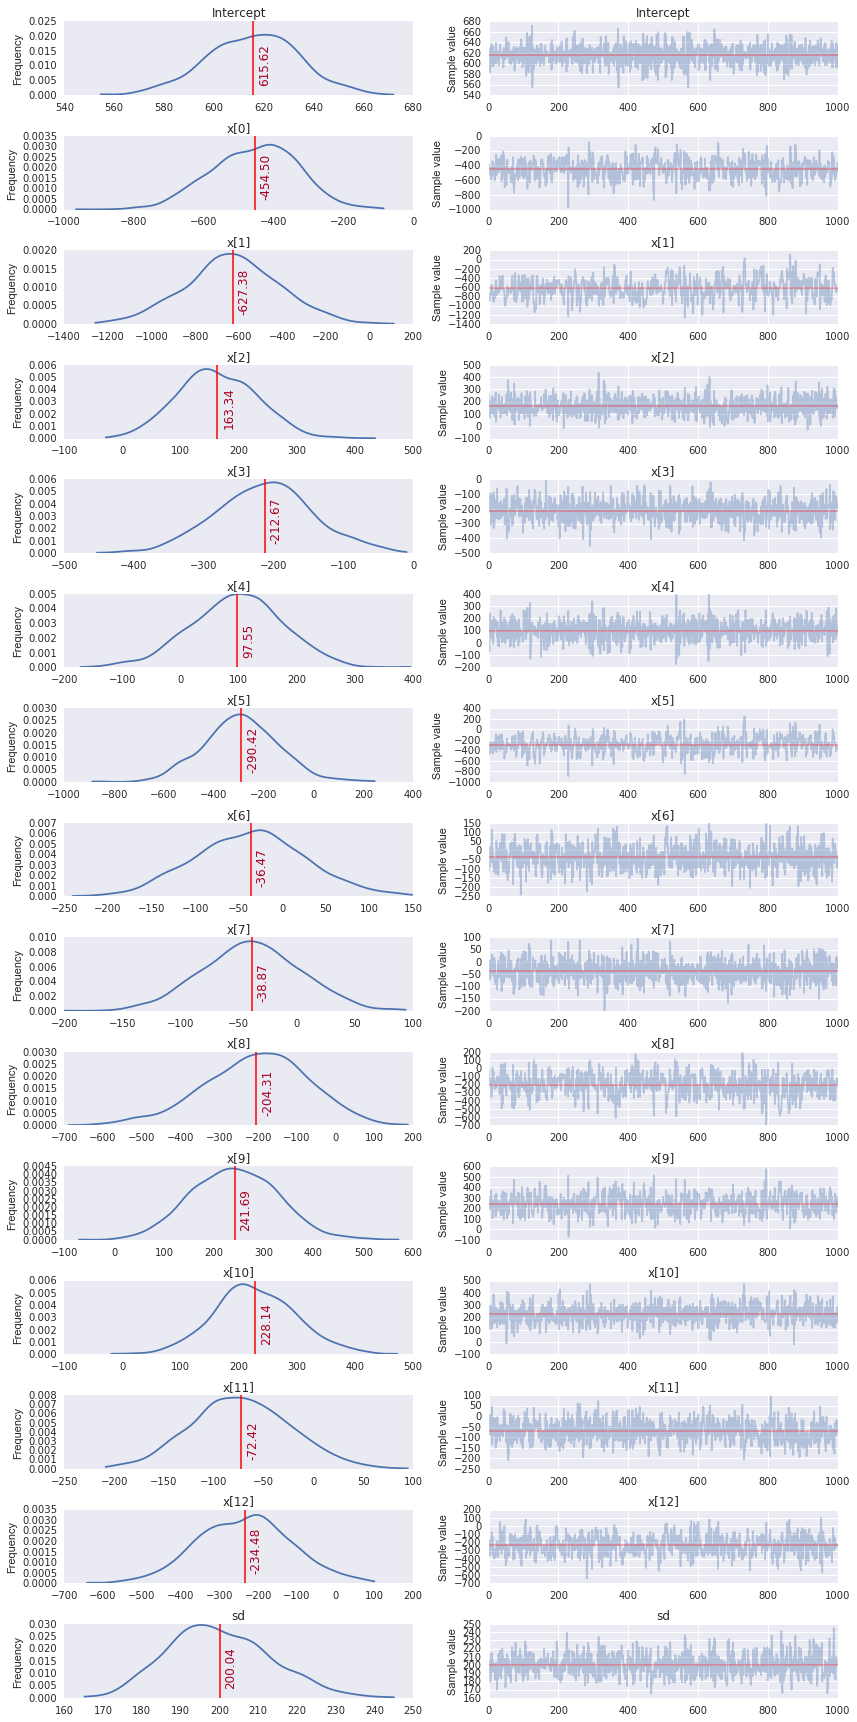

In [152]:
plot_traces(trc_pooled, retain=1000)

In [153]:
pm.df_summary(trc_pooled[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,615.618778,18.432346,0.526172,577.652745,650.906236
x[0],-454.499622,124.282755,5.653387,-697.365561,-238.388170
x[1],-627.384075,216.315966,11.696789,-1040.214914,-192.514018
x[2],163.339784,68.545225,2.123644,32.074642,288.846695
x[3],-212.671487,69.665640,2.693435,-353.526349,-80.191205
x[4],97.552134,79.809225,2.769520,-42.754793,265.542409
x[5],-290.420769,151.559357,7.861018,-574.749359,-1.323005
x[6],-36.468039,63.533855,2.623794,-152.163206,89.839730
x[7],-38.872030,42.423852,1.422024,-113.402204,48.410221
x[8],-204.307121,133.954795,6.599343,-450.992716,68.287490


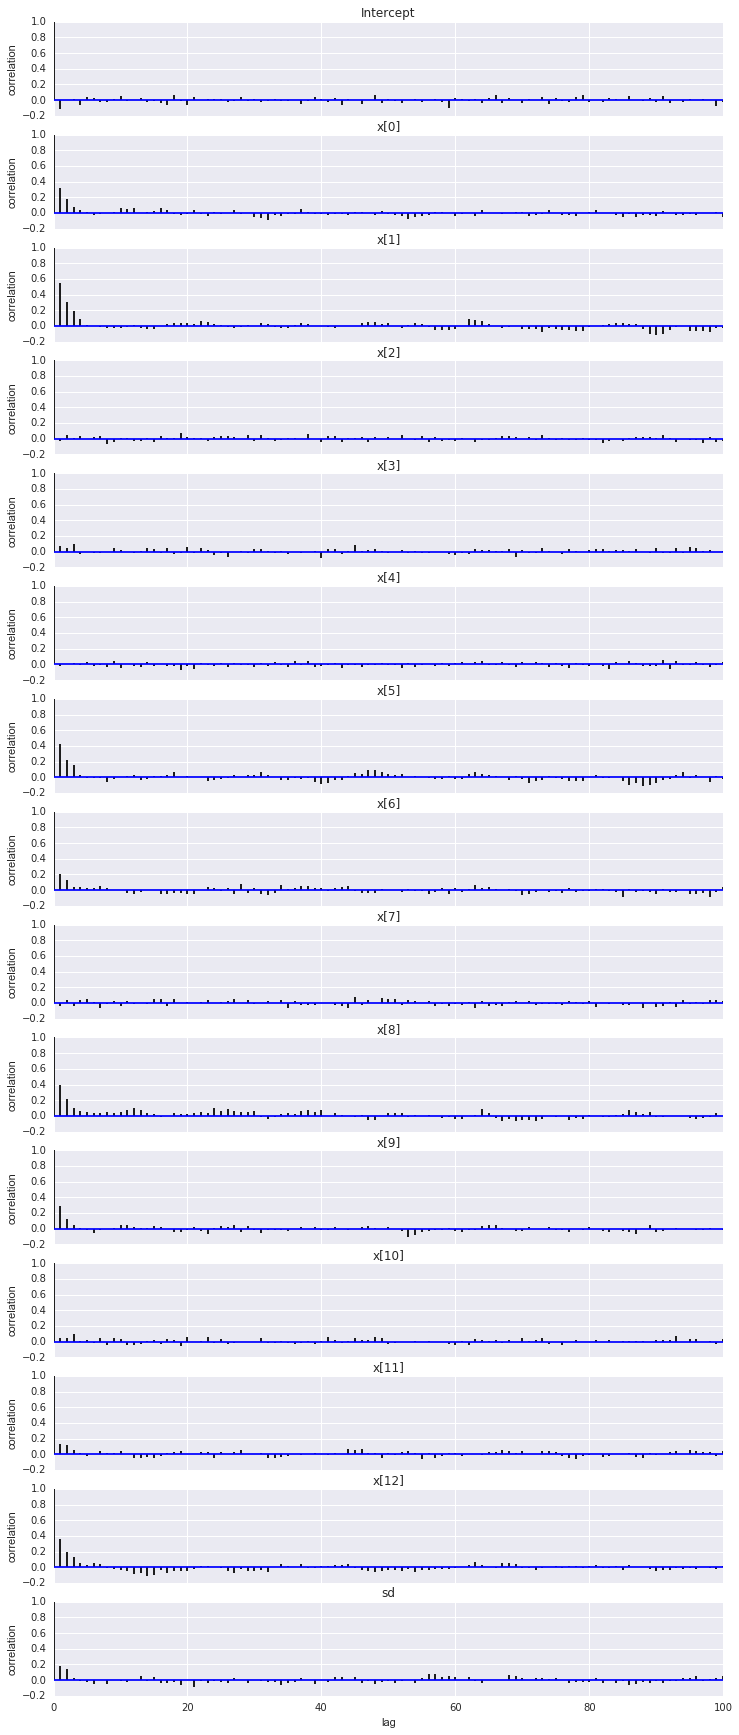

In [154]:
ax = pm.autocorrplot(trc_pooled[-1000:])

In [189]:
def compute_ppc(trc, mdl, samples=500, size=50):
    return pm.sample_ppc(trc, samples=500, model=mdl, size=50)

def compute_rmse(x, ppc, y):
    return np.sqrt(np.sum((ppc['y'].mean(0).mean(0).T - y)**2)[0]/x.shape[0])

def compute_r2(x, ppc, y):
    
    sse_model = np.sum((ppc['y'].mean(0).mean(0).T - y)**2)[0]
    sse_mean = np.sum((y - y.mean())**2)[0]
    
    return 1 - (sse_model / sse_mean)

In [192]:
ppc_pooled = compute_ppc(trc_pooled[-1000:], mdl_pooled, 500, 50)
rmse_pooled = compute_rmse(X_lasso_train_std, ppc_pooled, y_train)
r2_pooled = compute_r2(X_lasso_train_std, ppc_pooled, y_train)
print 'Train_RMSE: {0}'.format(rmse_pooled)
print 'Train_R2: {0}'.format(r2_pooled)

Train_RMSE: 188.582518723
Train_R2: 0.506428728759


In [206]:
plt.figure(figsize=(12, 60))
ax = fig.add_subplot(1,1,1)
ax.scatter(ppc_pooled['y'].mean(0).mean(0).T, y_train.values)

In [208]:
y_train.values.shape

(133, 1)

In [211]:
ppc_pooled['y'].mean(0).mean(0).T.shape

(133, 1)

In [213]:
predictors_shared = shared(y_train)

(-1000, 1000)

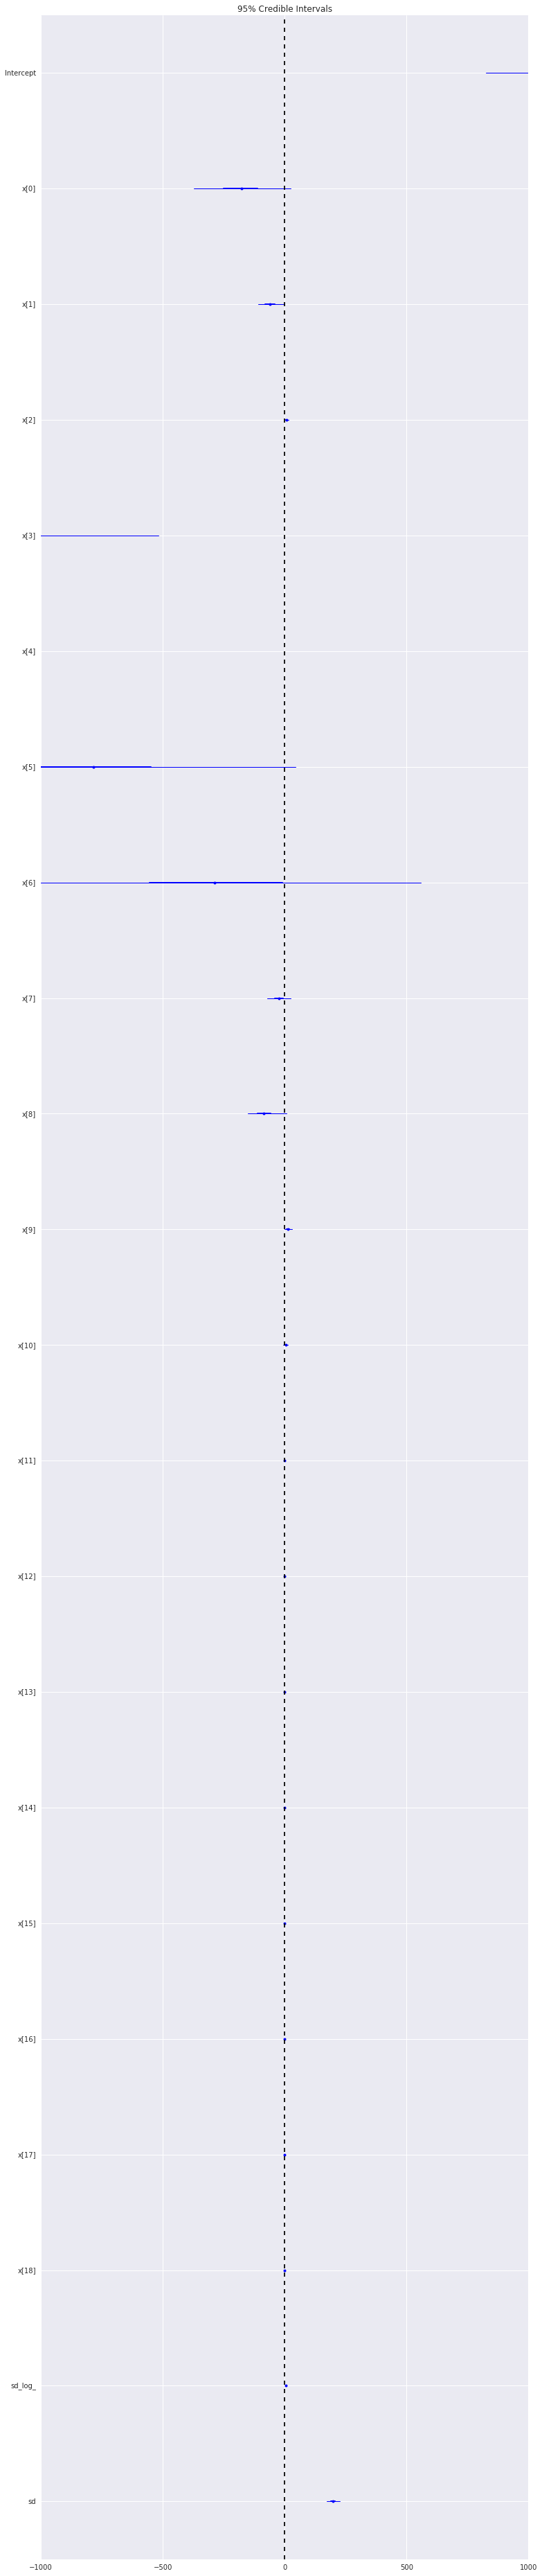

In [77]:
plt.figure(figsize=(12, 60))
pm.forestplot(traces)
# plt.savefig('../../Downloads/forestplot.png', dpi=400)
plt.xlim(-1000, 1000)

In [248]:
x = pd.concat((X_lasso_train_std, X_train['XEC_FIELD_Code']), axis=1)
x.columns

Index([u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft',
       u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc', u'Max_Prop_Conc',
       u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure',
       u'Fluid_Gal/Perf', u'XEC_FIELD_Code'],
      dtype='object')

In [255]:
with pm.Model() as mdl_unpooled:
   
    # define priors, use Normal
    b0 = pm.Normal('b0_XEC_FIELD_Code', mu=0, sd=100, shape=x['XEC_FIELD_Code'].nunique())
    b1 = pm.Normal('b1_Clusters/Stage', mu=0, sd=100)
    b2 = pm.Normal('b2_Perfs/Cluster', mu=0, sd=100)
    b3 = pm.Normal('b3_#_of_Stages', mu=0, sd=100)
    b4 = pm.Normal('b4_ISIP/Ft', mu=0, sd=100)
    b5 = pm.Normal('b5_Rate/Ft', mu=0, sd=100)
    b6 = pm.Normal('b6_Rate/Perf', mu=0, sd=100)
    b7 = pm.Normal('b7_Avg_Prop_Conc', mu=0, sd=100)
    b8 = pm.Normal('b8_Max_Prop_Conc', mu=0, sd=100)
    b9 = pm.Normal('b9_Rate/Cluster', mu=0, sd=100)
    b10 = pm.Normal('b10_Max_Rate', mu=0, sd=100)
    b11 = pm.Normal('b11_Avg_Pressure', mu=0, sd=100)
    b12 = pm.Normal('b12_Max_Pressure', mu=0, sd=100)    
    b13 = pm.Normal('b13_Fluid_Gal/Perf', mu=0, sd=100)    
    
    # define linear model
    yest = ( b0[x['XEC_FIELD_Code']] +
             b1 * x['Clusters/Stage'] + 
             b2 * x['Perfs/Cluster'] +
             b3 * x['#_of_Stages'] +
             b4 * x['ISIP/Ft'] +
             b5 * x['Rate/Ft'] +
             b6 * x['Rate/Perf'] +
             b7 * x['Avg_Prop_Conc'] +
             b8 * x['Max_Prop_Conc'] +
             b9 * x['Rate/Cluster'] +
             b10 * x['Max_Rate'] +
             b11 * x['Avg_Pressure'] +
             b12 * x['Max_Pressure'] +
             b13 * x['Fluid_Gal/Perf'])

    ## Student T likelihood with fixed degrees of freedom nu
    epsilon = pm.HalfCauchy('epsilon', beta=10)
    likelihood = pm.StudentT('likelihood', nu=1, mu=yest, sd=epsilon, observed=y_train)
 
    step = pm.NUTS()
    trc_unpooled = pm.sample(2000, step, progressbar=True)


Applied log-transform to epsilon and added transformed epsilon_log_ to model.
INFO:pymc3:Applied log-transform to epsilon and added transformed epsilon_log_ to model.
100%|██████████| 2000/2000 [05:00<00:00,  8.03it/s]


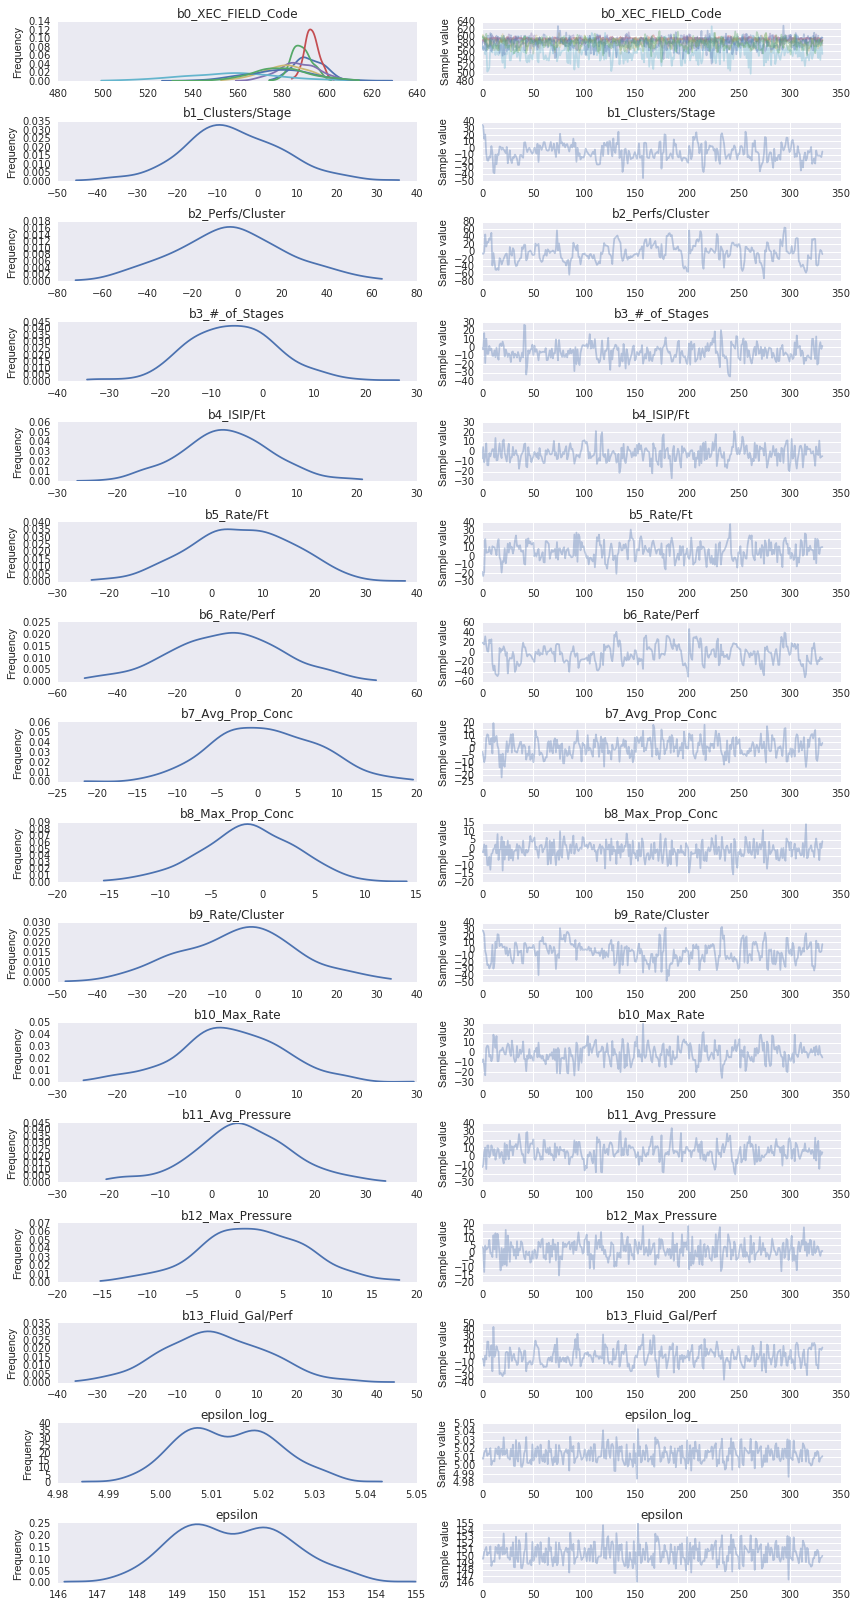

In [256]:
rvs_unpooled = [rv.name for rv in mdl_unpooled.unobserved_RVs]
ax = pm.traceplot(trc_unpooled[-333:], varnames=rvs_unpooled, figsize=(12,len(rvs_unpooled)*1.4), combined=False)